In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py
import time
import random
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/data/p003949.mat"
TEST_SET_PATH = "/content/drive/MyDrive/Colab Notebooks/data/p009993.mat"
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [4]:
def seed_everything(seed):
    """
    모든 random seed를 고정하는 함수
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
seed_everything(SEED)

print(f"Random seed set to {SEED}")

Random seed set to 42


In [5]:
def load_data(mat_path):

    with h5py.File(mat_path, 'r') as f:
        refs = f['Subj_Wins']

        ppg_list = [f[r][()].squeeze() for r in refs['PPG_F'][0]]
        ecg_list = [f[r][()].squeeze() for r in refs['ECG_F'][0]]
        sbp_list = [f[r][()][0][0] for r in refs['SegSBP'][0]]
        dbp_list = [f[r][()][0][0] for r in refs['SegDBP'][0]]

        ppg_all = np.array(ppg_list, dtype=np.float32)
        ecg_all = np.array(ecg_list, dtype=np.float32)
        sbp_all = np.array(sbp_list, dtype=np.float32)
        dbp_all = np.array(dbp_list, dtype=np.float32)

    print(f'PPG 신호 shape:  {ppg_all.shape}')
    print(f'ECG 신호 shape:  {ecg_all.shape}')
    print(f'SBP 신호 shape:  {sbp_all.shape}')
    print(f'DBP 신호 shape:  {dbp_all.shape}')

    return ppg_all, ecg_all, sbp_all, dbp_all

In [6]:
def chronological_split(X_data, y_data, n_folds=5, n_total_segments=2000):

    # 2000개 segment만 사용
    X = X_data[:n_total_segments]
    y = y_data[:n_total_segments]

    fold_size = n_total_segments // n_folds
    train_size, val_size, test_size = 320, 40, 40

    folds=[]
    for i in range(n_folds):
        start_idx = i * fold_size
        train_end_idx = start_idx + train_size
        val_end_idx = train_end_idx + val_size
        test_end_idx = val_end_idx + test_size

        X_train, y_train = X[start_idx:train_end_idx], y[start_idx:train_end_idx]
        X_val, y_val = X[train_end_idx:val_end_idx], y[train_end_idx:val_end_idx]
        X_test, y_test = X[val_end_idx:test_end_idx], y[val_end_idx:test_end_idx]

        folds.append((X_train, X_val, X_test, y_train, y_val, y_test))

    return folds

In [7]:
class CNN_LSTM_Regressor(nn.Module):
    def __init__(self, cnn_output_channels=128, lstm_hidden_size=256, lstm_num_layers=1):
        super().__init__()

        self.cnn_extractor = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=32, kernel_size=7, padding='same'),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2), # 길이: 1250 -> 625

            nn.Conv1d(32, 64, kernel_size=7, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2), # 길이: 625 -> 312

            nn.Conv1d(64, cnn_output_channels, kernel_size=7, padding='same'),
            nn.BatchNorm1d(cnn_output_channels),
            nn.ReLU(),
            nn.MaxPool1d(2)  # 길이: 312 -> 156
        )

        self.lstm = nn.LSTM(
            input_size=cnn_output_channels,  # CNN의 마지막 출력 채널 수
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True  # (배치, 시퀀스, 특징) 순서
        )

        # Regressor (Classifier 대신)
        self.regressor = nn.Sequential(
            nn.Linear(lstm_hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)  # 최종 출력 2개: SBP, DBP
        )

    def forward(self, x):
        # 입력: (배치, 길이, 채널)
        x = x.permute(0, 2, 1) # CNN 입력을 위해 (배치, 채널, 길이)로 변경

        # CNN 특징 추출
        features = self.cnn_extractor(x)

        # LSTM 입력을 위해 (배치, 시퀀스 길이, 특징 수)로 변경
        features = features.permute(0, 2, 1)

        # LSTM 처리
        # LSTM은 마지막 hidden state인 hn만 사용
        _, (hn, _) = self.lstm(features)

        # 마지막 레이어의 hidden state 사용 (many-to-one 구조)
        out = hn[-1]

        # 최종 회귀 예측
        out = self.regressor(out)
        return out

In [8]:
def train_model_v2(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, patience, fold_idx):
    """학습률 스케줄러와 조기 종료가 포함된 훈련 함수"""

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
        val_loss /= len(val_loader)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'best_model_fold_{fold_idx}.pth')
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'  Epoch [{epoch+1}/{epochs}], Val Loss: {val_loss:.4f}')

        if patience_counter >= patience:
            print(f"  > 조기 종료: {patience} 에포크 동안 성능 개선 없음")
            break

    model.load_state_dict(torch.load(f'best_model_fold_{fold_idx}.pth'))
    return model

In [9]:
def evaluate_model(model, test_loader, device):
    """훈련된 모델 평가를 위한 함수"""
    model.eval()
    all_preds = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs.to(device))
            all_preds.append(outputs.cpu().numpy())
    return np.concatenate(all_preds, axis=0)

In [10]:
def plot_prediction(y_true, y_pred, fold_idx):
    """
    실제값, 예측값, 그리고 예측 범위를 함께 시각화하는 함수
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = {
        'true': '#007ACC',      # 시원한 파란색
        'pred_sbp': '#FF4500',  # 강조되는 주황색
        'range_sbp': '#FFC1B5', # 연한 주황색
        'pred_dbp': '#2CA02C',  # 차분한 녹색
        'range_dbp': '#B8E0B8', # 연한 녹색
        'text': '#333333'
    }

    # SBP/DBP 분리 및 MAE 계산
    sbp_true, dbp_true = y_true[:, 0], y_true[:, 1]
    sbp_pred, dbp_pred = y_pred[:, 0], y_pred[:, 1]

    mae_sbp = np.mean(np.abs(sbp_true - sbp_pred))
    mae_dbp = np.mean(np.abs(dbp_true - dbp_pred))

    # x축으로 사용할 인덱스 생성
    x_axis = np.arange(len(sbp_true))

    # --- 시각화 ---

    if isinstance(fold_idx, int):
        title = f'Fold {fold_idx + 1}: Blood Pressure Prediction Analysis'
    else:
        # fold_idx가 "New Patient" 같은 문자열일 경우
        title = f'{fold_idx} Analysis: Blood Pressure Prediction'

    fig, axes = plt.subplots(2, 1, figsize=(18, 11), sharex=True)
    fig.suptitle(title, fontsize=22, weight='bold', color=colors['text'])
    fig.patch.set_facecolor('#F8F8F8')

    # --- SBP Plot ---
    ax1 = axes[0]
    ax1.fill_between(x_axis, (sbp_pred - mae_sbp), (sbp_pred + mae_sbp),
                     color=colors['range_sbp'], alpha=0.7, label=f'Prediction Range (±{mae_sbp:.2f} MAE)')
    ax1.plot(x_axis, sbp_true, color=colors['true'], label='True SBP', linewidth=2)
    ax1.plot(x_axis, sbp_pred, color=colors['pred_sbp'], label='Predicted SBP', linewidth=2.5, linestyle='--')

    ax1.set_title('Systolic Blood Pressure (SBP)', fontsize=16, color=colors['text'], pad=10)
    ax1.set_ylabel('mmHg', fontsize=12, color=colors['text'])
    ax1.tick_params(axis='both', which='major', labelsize=11)
    ax1.legend(fontsize=12, loc='upper right')
    ax1.set_facecolor('#FFFFFF') # Plot 배경색

    # --- DBP Plot ---
    ax2 = axes[1]
    ax2.fill_between(x_axis, (dbp_pred - mae_dbp), (dbp_pred + mae_dbp),
                     color=colors['range_dbp'], alpha=0.7, label=f'Prediction Range (±{mae_dbp:.2f} MAE)')
    ax2.plot(x_axis, dbp_true, color=colors['true'], label='True DBP', linewidth=2)
    ax2.plot(x_axis, dbp_pred, color=colors['pred_dbp'], label='Predicted DBP', linewidth=2.5, linestyle='--')

    ax2.set_title('Diastolic Blood Pressure (DBP)', fontsize=16, color=colors['text'], pad=10)
    ax2.set_xlabel('Test Sample Index', fontsize=14, color=colors['text'], labelpad=10)
    ax2.set_ylabel('mmHg', fontsize=12, color=colors['text'])
    ax2.tick_params(axis='both', which='major', labelsize=11)
    ax2.legend(fontsize=12, loc='upper right')
    ax2.set_facecolor('#FFFFFF')

    # 테두리 정리
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

==================== PPG+ECG Model Execution ====================
Using device: cuda
PPG 신호 shape:  (2376, 1250)
ECG 신호 shape:  (2376, 1250)
SBP 신호 shape:  (2376,)
DBP 신호 shape:  (2376,)


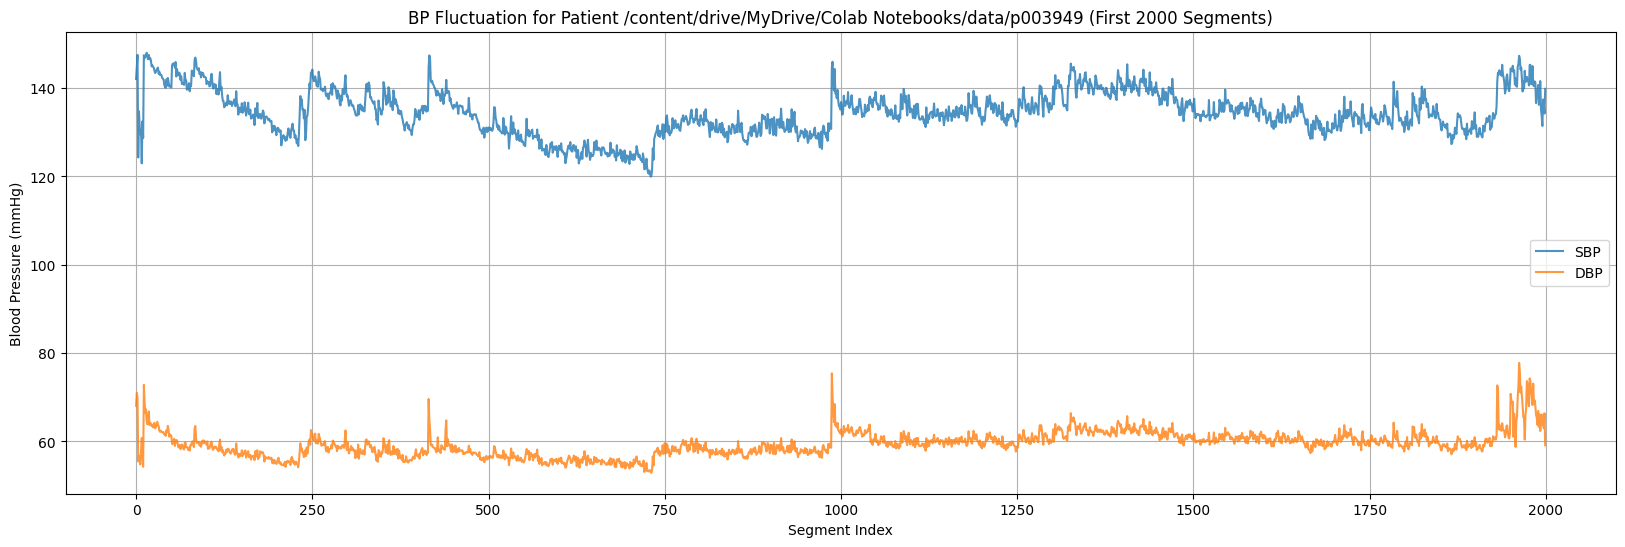


===== Fold 1/5 시작 =====
Fold 1: 모델 훈련 중...
  Epoch [10/150], Val Loss: 1766.6777
  Epoch [20/150], Val Loss: 14.3053
  Epoch [30/150], Val Loss: 3.8546
  > 조기 종료: 10 에포크 동안 성능 개선 없음
Fold 1 완료. (소요 시간: 5.34초)


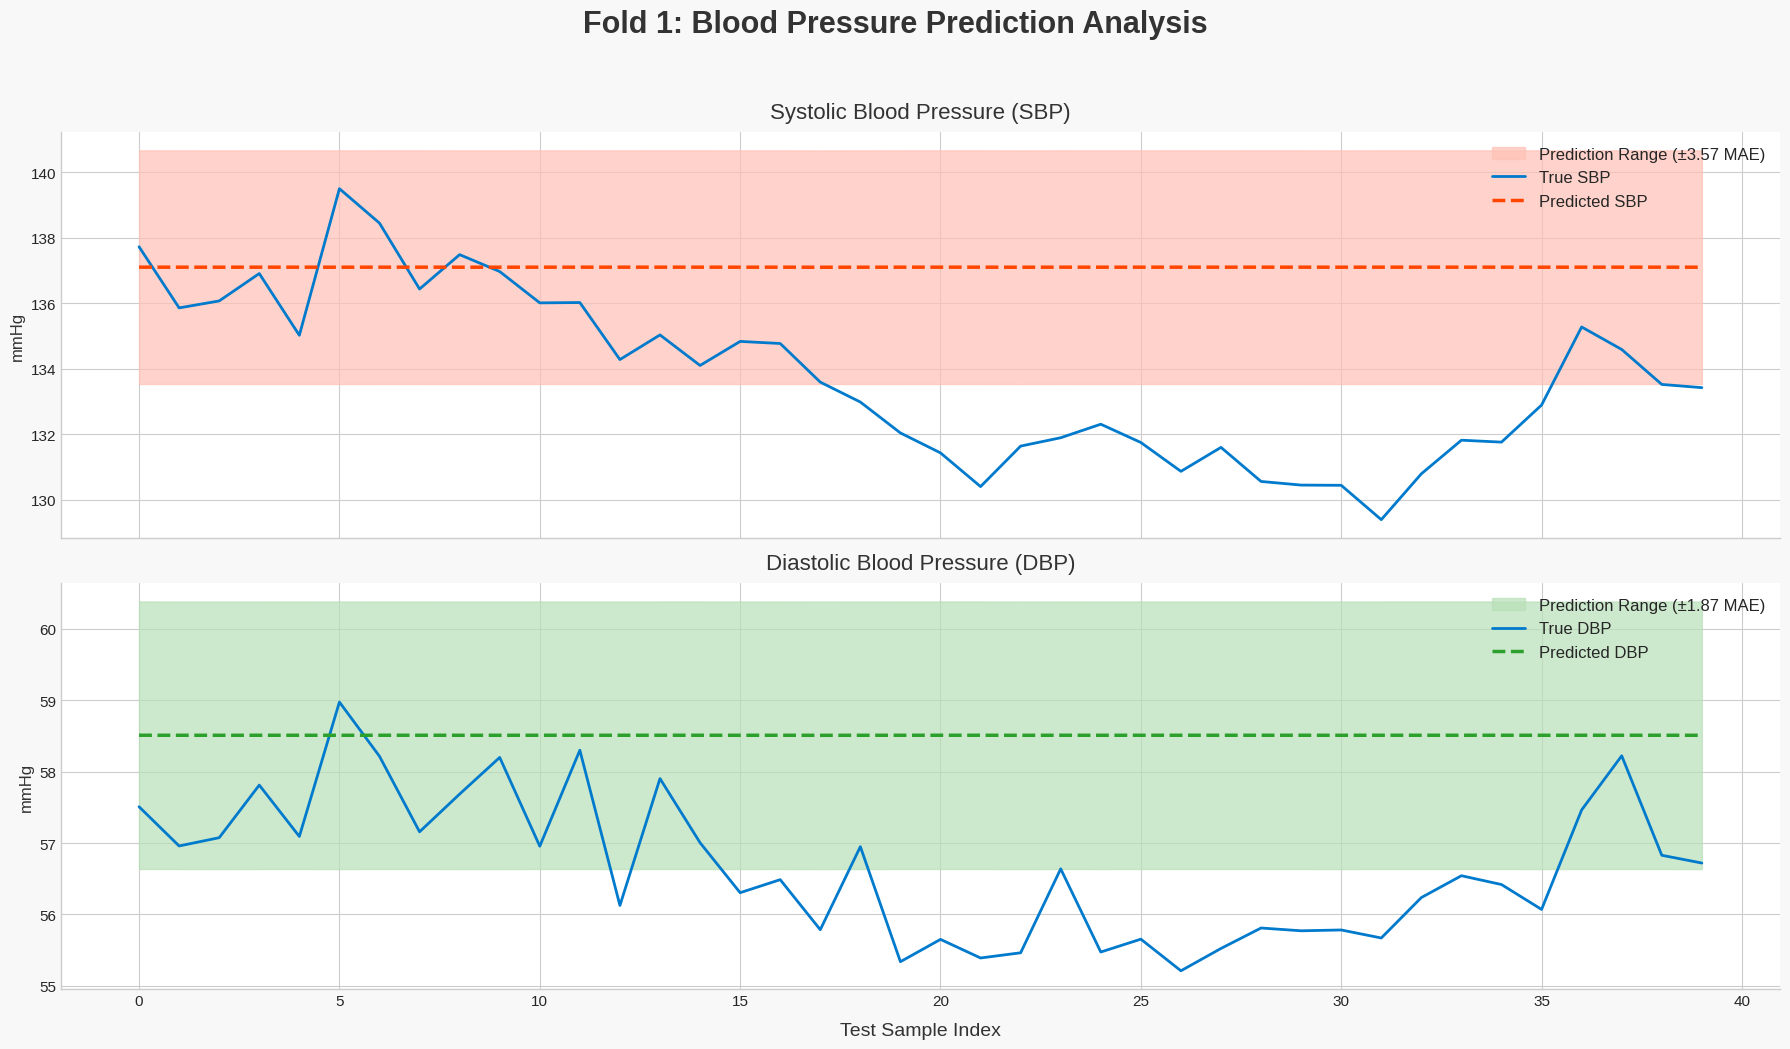


===== Fold 2/5 시작 =====
Fold 2: 모델 훈련 중...
  Epoch [10/150], Val Loss: 1616.1337
  Epoch [20/150], Val Loss: 25.9039
  Epoch [30/150], Val Loss: 12.7986
  > 조기 종료: 10 에포크 동안 성능 개선 없음
Fold 2 완료. (소요 시간: 4.16초)


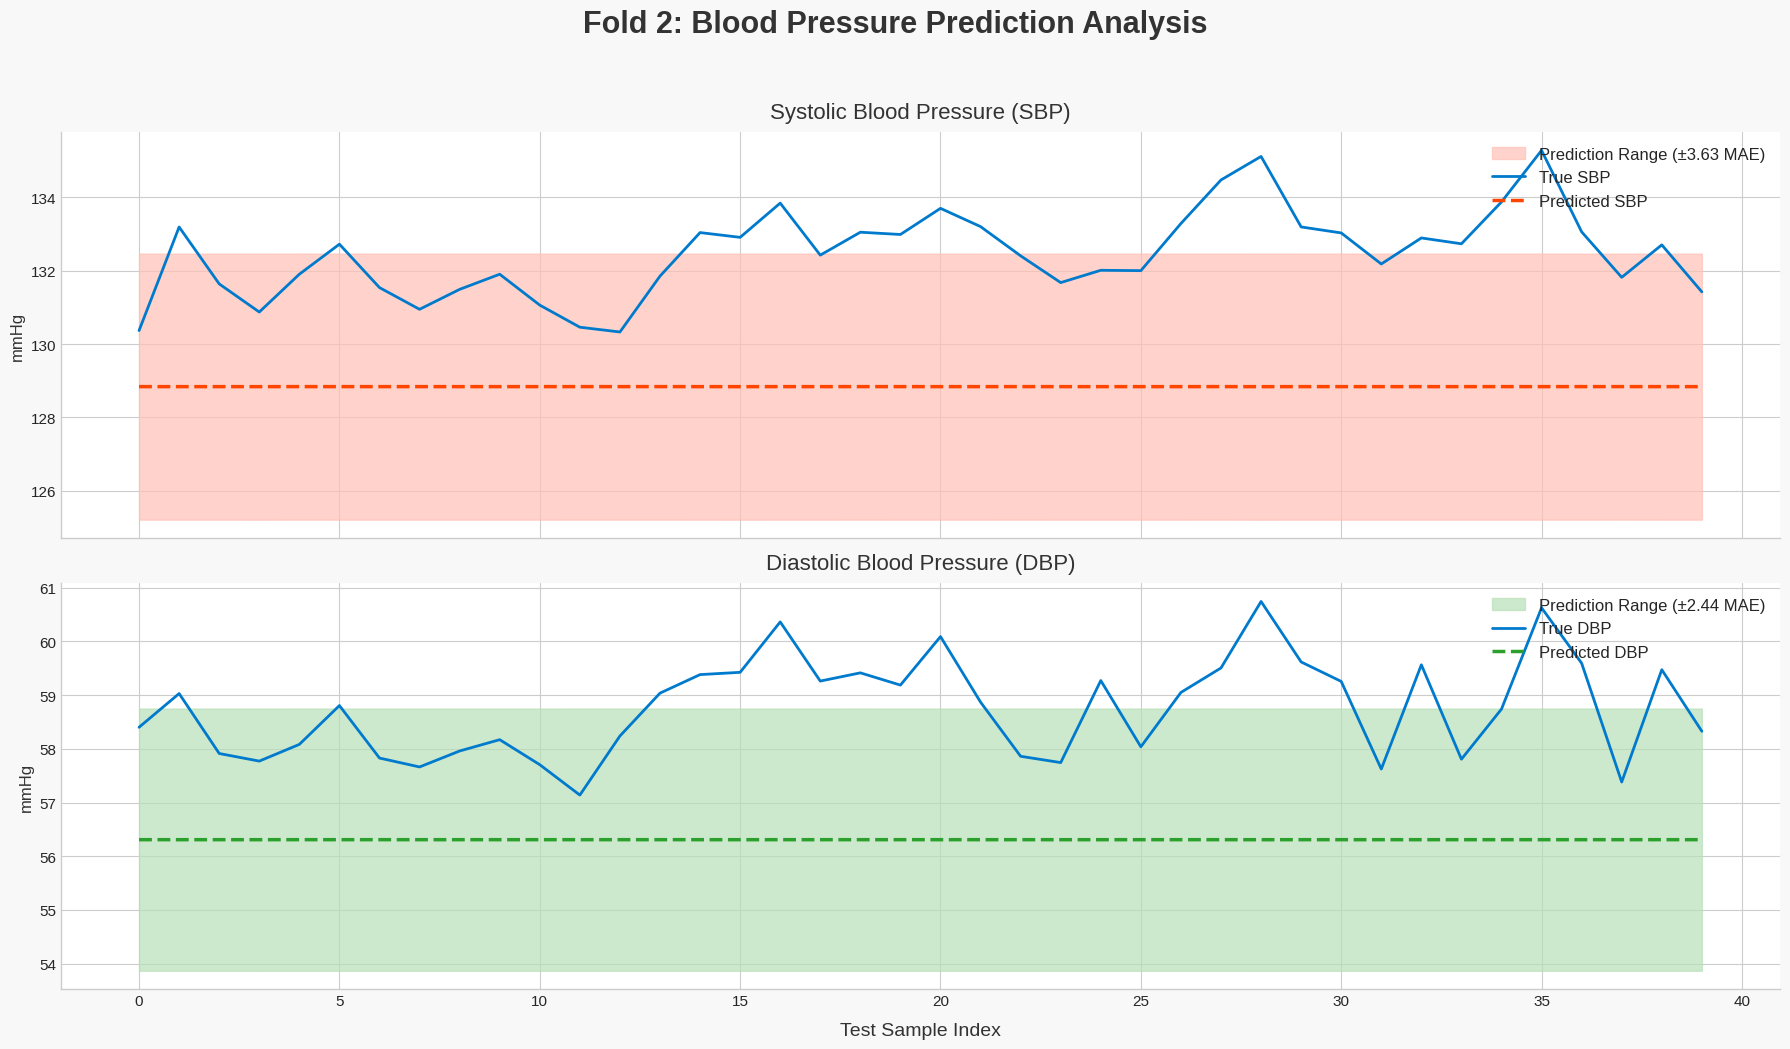


===== Fold 3/5 시작 =====
Fold 3: 모델 훈련 중...
  Epoch [10/150], Val Loss: 1569.6660
  Epoch [20/150], Val Loss: 7.7279
  > 조기 종료: 10 에포크 동안 성능 개선 없음
Fold 3 완료. (소요 시간: 2.98초)


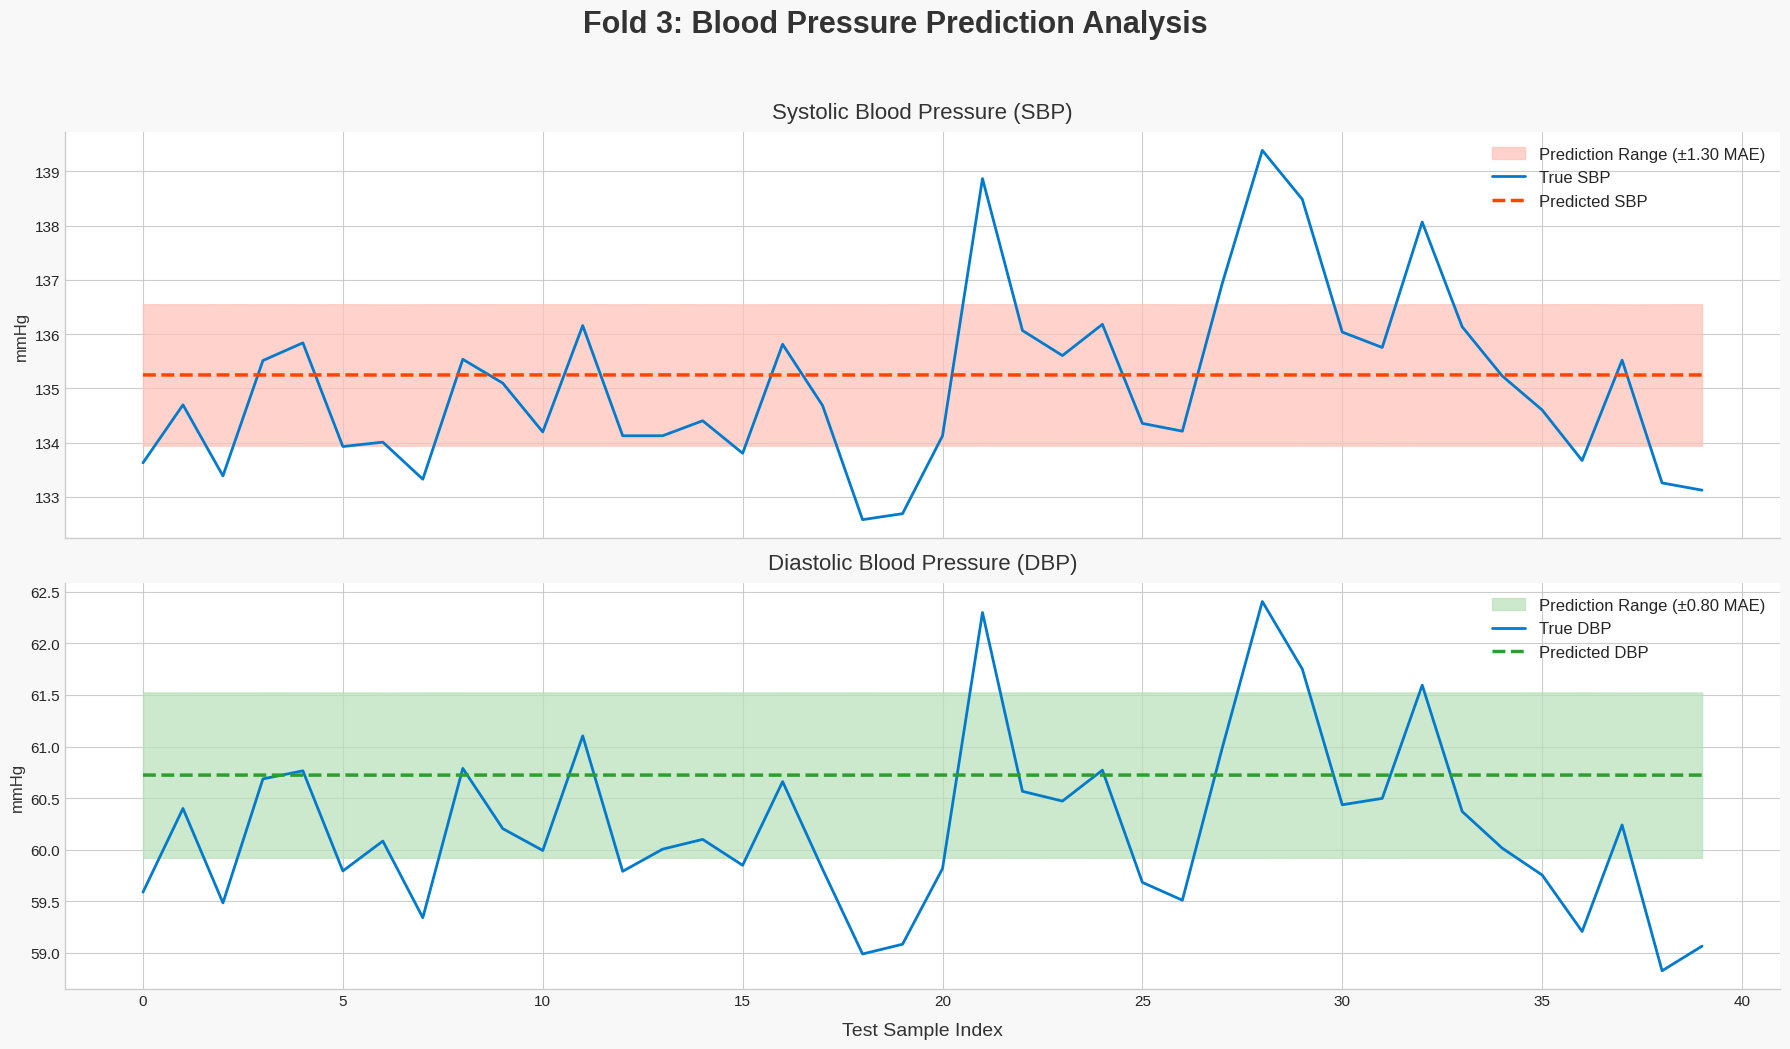


===== Fold 4/5 시작 =====
Fold 4: 모델 훈련 중...
  Epoch [10/150], Val Loss: 2100.7539
  Epoch [20/150], Val Loss: 17.4465
  Epoch [30/150], Val Loss: 4.4105
  Epoch [40/150], Val Loss: 3.7547
  > 조기 종료: 10 에포크 동안 성능 개선 없음
Fold 4 완료. (소요 시간: 4.81초)


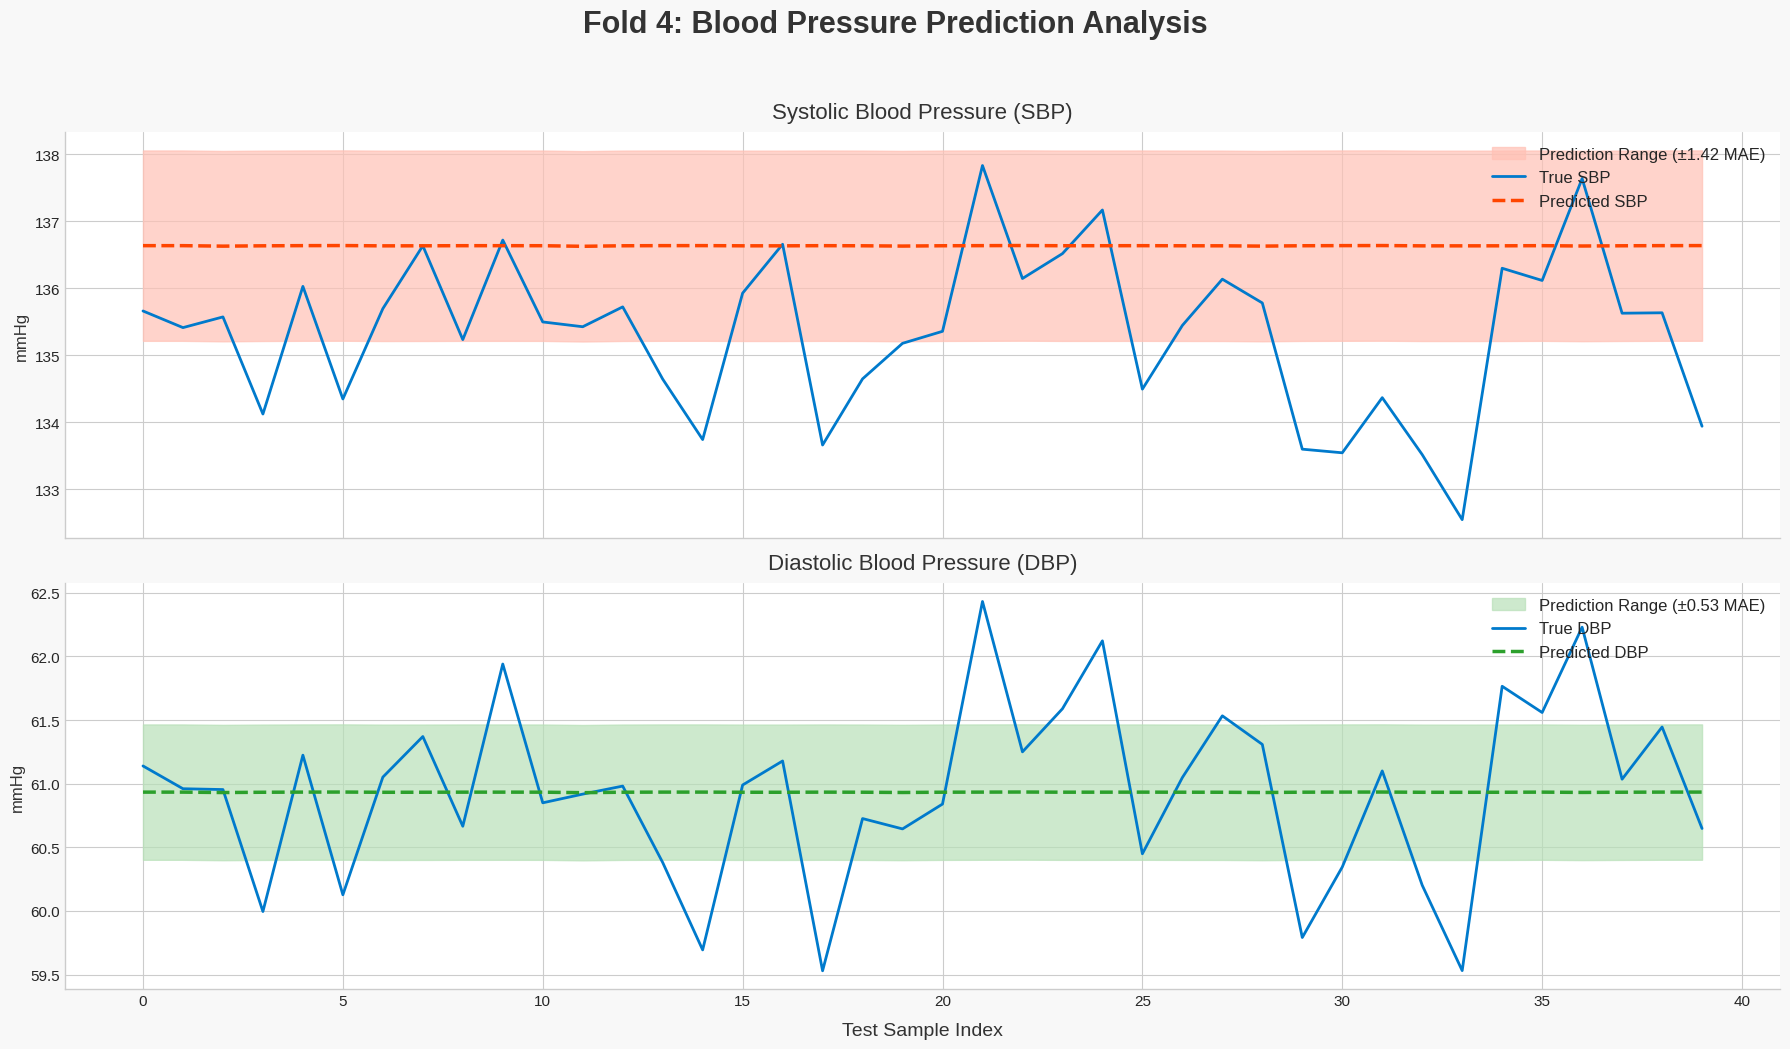


===== Fold 5/5 시작 =====
Fold 5: 모델 훈련 중...
  Epoch [10/150], Val Loss: 1874.9489
  Epoch [20/150], Val Loss: 41.0182
  > 조기 종료: 10 에포크 동안 성능 개선 없음
Fold 5 완료. (소요 시간: 2.94초)


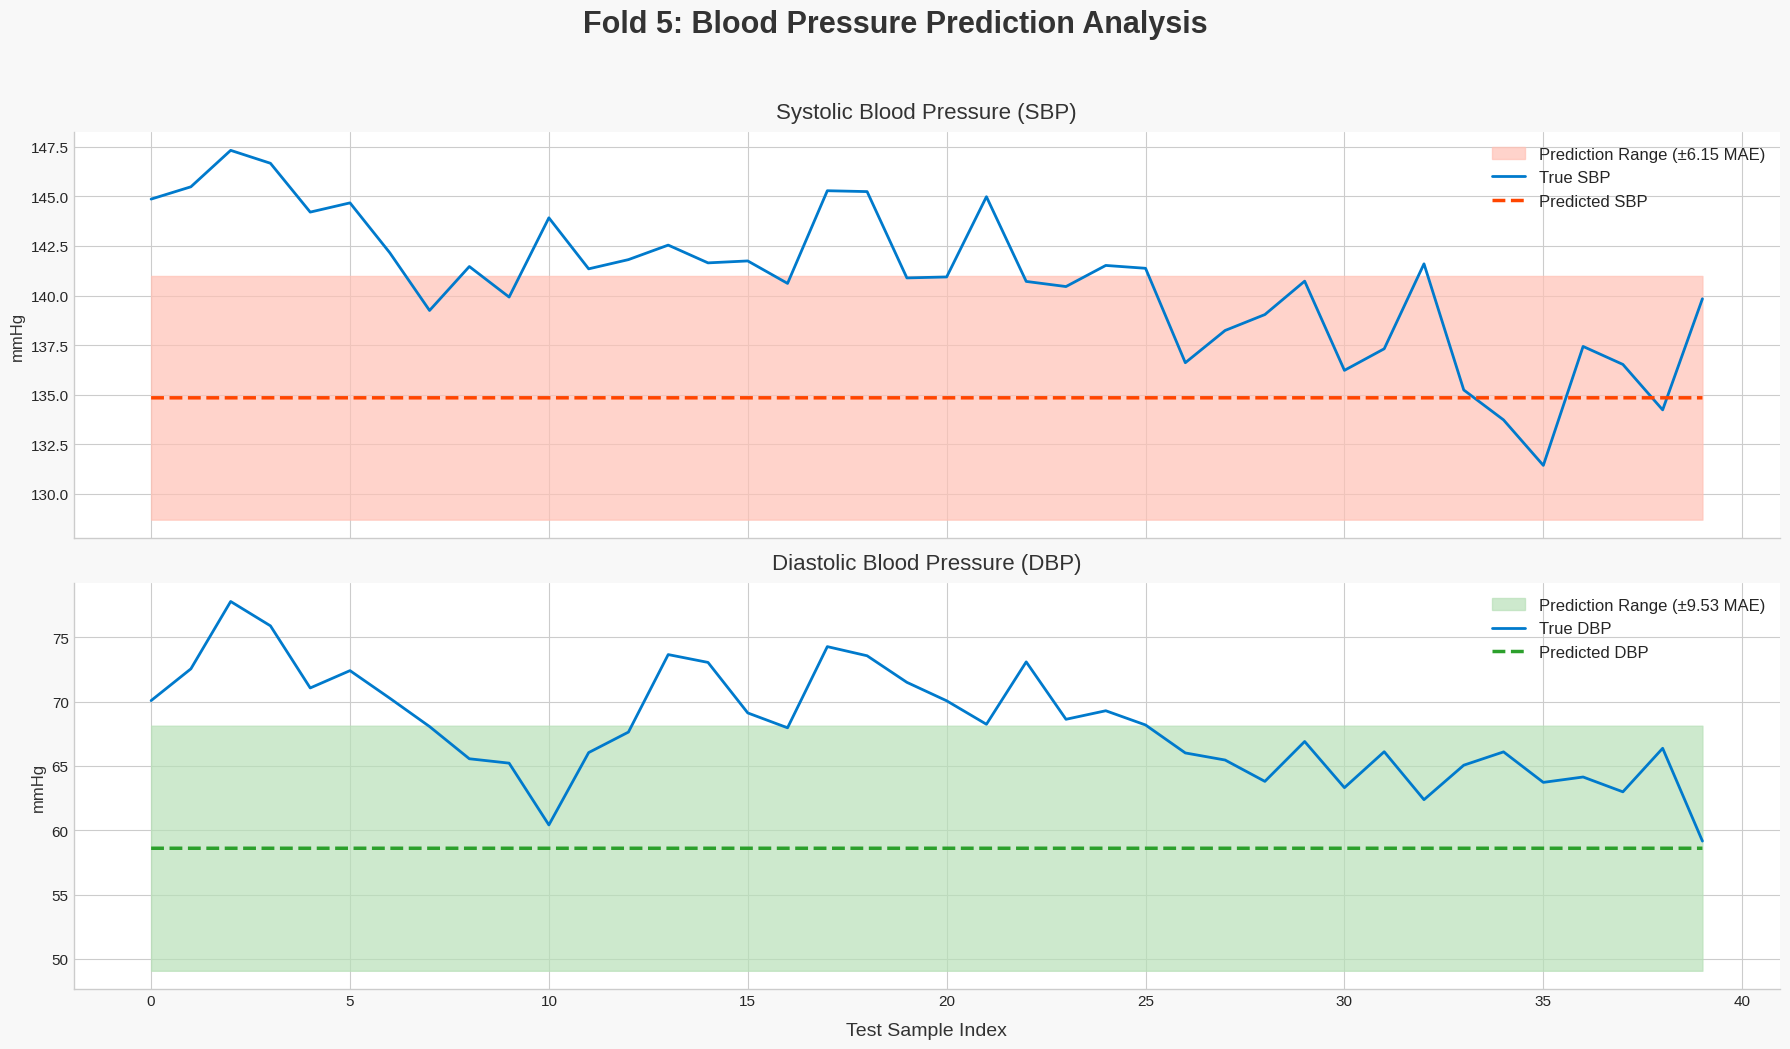



===== 최종 결과 요약  =====
사용한 환자 번호: /content/drive/MyDrive/Colab Notebooks/data/p003949
      SBP MAE  DBP MAE  SBP RMSE  DBP RMSE
Fold                                      
1       3.567    1.874     4.185     2.094
2       3.629    2.440     3.813     2.605
3       1.304    0.801     1.619     0.966
4       1.420    0.532     1.740     0.693
5       6.145    9.525     6.913    10.407

--- 평균 및 표준편차 ---
      SBP MAE  DBP MAE  SBP RMSE  DBP RMSE
mean    3.213    3.034     3.654     3.353
std     1.985    3.711     2.164     4.021


In [11]:
def main():
    seed_everything(SEED)
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"{'='*20} PPG+ECG Model Execution {'='*20}")
    print(f"Using device: {DEVICE}")

    ppg, ecg, sbp, dbp = load_data(FILE_PATH)

    # --- 전체 혈압 변동 그래프 시각화 ---
    plt.figure(figsize=(20, 6))
    plt.plot(sbp[:2000], label='SBP', alpha=0.8)
    plt.plot(dbp[:2000], label='DBP', alpha=0.8)
    plt.title(f'BP Fluctuation for Patient {FILE_PATH.split(".")[0]} (First 2000 Segments)')
    plt.xlabel('Segment Index'); plt.ylabel('Blood Pressure (mmHg)'); plt.legend(); plt.grid(True)
    plt.show()

    # --- PPG+ECG 데이터 준비 ---
    X_data = np.stack([ppg, ecg], axis=-1)
    y_data = np.stack([sbp, dbp], axis=-1)
    all_folds_data = chronological_split(X_data, y_data)

    fold_results = []
    for i, (X_train, X_val, X_test, y_train, y_val, y_test) in enumerate(all_folds_data):
        start_time = time.time()
        print(f"\n===== Fold {i+1}/5 시작 =====")

        # --- 데이터 스케일링 및 DataLoader 생성 ---
        scaler = StandardScaler().fit(X_train.reshape(-1, X_train.shape[-1]))
        X_train_scaled = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
        X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

        train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

        # --- 모델 훈련 ---
        model = CNN_LSTM_Regressor().to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
        criterion = nn.MSELoss()
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

        print(f"Fold {i+1}: 모델 훈련 중...")
        model = train_model_v2(model, train_loader, val_loader, criterion, optimizer, scheduler, DEVICE, EPOCHS, patience=10, fold_idx=i)

        # --- 모델 평가 ---
        y_pred = evaluate_model(model, test_loader, DEVICE)
        mae_sbp = np.mean(np.abs(y_test[:, 0] - y_pred[:, 0]))
        mae_dbp = np.mean(np.abs(y_test[:, 1] - y_pred[:, 1]))
        rmse_sbp = np.sqrt(np.mean((y_test[:, 0] - y_pred[:, 0])**2))
        rmse_dbp = np.sqrt(np.mean((y_test[:, 1] - y_pred[:, 1])**2))
        fold_results.append({'Fold': i+1, 'SBP MAE': mae_sbp, 'DBP MAE': mae_dbp, 'SBP RMSE': rmse_sbp, 'DBP RMSE': rmse_dbp})

        print(f"Fold {i+1} 완료. (소요 시간: {time.time() - start_time:.2f}초)")
        plot_prediction(y_test, y_pred, i)

    # --- 최종 결과 분석 ---
    results_df = pd.DataFrame(fold_results).set_index('Fold')
    summary = results_df.agg(['mean', 'std'])
    print("\n\n===== 최종 결과 요약  =====")
    print(f"사용한 환자 번호: {FILE_PATH.split('.')[0]}")
    print(results_df.round(3))
    print("\n--- 평균 및 표준편차 ---")
    print(summary.round(3))

if __name__ == '__main__':
    main()


In [12]:
def train_final_model(train_patient_path):
    """한 명의 환자 데이터 전체로 최종 모델을 학습 및 저장"""
    print(f"\n{'='*20} 최종 모델 훈련 시작 ({train_patient_path}) {'='*20}")
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1. 훈련용 환자 데이터 로드
    ppg, ecg, sbp, dbp = load_data(train_patient_path)
    X_train_full = np.stack([ppg, ecg], axis=-1)[:2000]
    y_train_full = np.stack([sbp, dbp], axis=-1)[:2000]

    # 2. 정규화 및 정규화 정보 저장
    scaler = StandardScaler().fit(X_train_full.reshape(-1, X_train_full.shape[-1]))
    import pickle
    save_path = 'drive/MyDrive/Colab Notebooks/data/final_scaler.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(scaler, f)

    X_train_scaled = scaler.transform(X_train_full.reshape(-1, X_train_full.shape[-1])).reshape(X_train_full.shape)

    # 3. DataLoader 준비
    train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train_full, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) # 셔플은 False로 유지

    # 4. 모델 훈련 (검증 데이터 없이 전체 데이터로 훈련)
    model = CNN_LSTM_Regressor().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(40): # 고정된 에포크만큼 훈련 (예: 40)
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f"  Epoch [{epoch+1}/40] 훈련 완료")

    # 5. 최종 모델 저장
    torch.save(model.state_dict(), 'final_model.pth')
    print("최종 모델 'final_model.pth' 저장 완료!")

In [13]:
def evaluate_on_new_patient(test_patient_path):
    """저장된 모델과 스케일러로 새로운 환자를 평가하는 함수"""
    print(f"\n{'='*20} 새로운 환자 평가 시작 ({test_patient_path}) {'='*20}")
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1. 테스트용 환자 데이터 로딩
    ppg, ecg, sbp, dbp = load_data(test_patient_path)
    X_test_new = np.stack([ppg, ecg], axis=-1)[:2000]
    y_test_new = np.stack([sbp, dbp], axis=-1)[:2000]

    # 2. 저장된 스케일러 불러오기
    import pickle
    with open('drive/MyDrive/Colab Notebooks/data/final_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    X_test_scaled = scaler.transform(X_test_new.reshape(-1, X_test_new.shape[-1])).reshape(X_test_new.shape)

    # 3. DataLoader 준비
    test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test_new, dtype=torch.float32))
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # 4. 저장된 모델 구조를 만들고 가중치 불러오기
    model = CNN_LSTM_Regressor().to(DEVICE)
    model.load_state_dict(torch.load('final_model.pth'))

    # 5. 평가 수행
    y_pred_new = evaluate_model(model, test_loader, DEVICE)

    # 6. 결과 출력 및 시각화
    mae_sbp = np.mean(np.abs(y_test_new[:, 0] - y_pred_new[:, 0]))
    mae_dbp = np.mean(np.abs(y_test_new[:, 1] - y_pred_new[:, 1]))

    print(f"\n--- 새로운 환자({test_patient_path}) 최종 평가 결과 ---")
    print(f"  > SBP MAE: {mae_sbp:.3f}")
    print(f"  > DBP MAE: {mae_dbp:.3f}")

    plot_prediction(y_test_new, y_pred_new, fold_idx="New Patient")


==================== 최종 모델 훈련 시작 (/content/drive/MyDrive/Colab Notebooks/data/p003949.mat) ====================
PPG 신호 shape:  (2376, 1250)
ECG 신호 shape:  (2376, 1250)
SBP 신호 shape:  (2376,)
DBP 신호 shape:  (2376,)
  Epoch [10/40] 훈련 완료
  Epoch [20/40] 훈련 완료
  Epoch [30/40] 훈련 완료
  Epoch [40/40] 훈련 완료
최종 모델 'final_model.pth' 저장 완료!

==================== 새로운 환자 평가 시작 (/content/drive/MyDrive/Colab Notebooks/data/p009993.mat) ====================
PPG 신호 shape:  (2050, 1250)
ECG 신호 shape:  (2050, 1250)
SBP 신호 shape:  (2050,)
DBP 신호 shape:  (2050,)

--- 새로운 환자(/content/drive/MyDrive/Colab Notebooks/data/p009993.mat) 최종 평가 결과 ---
  > SBP MAE: 20.365
  > DBP MAE: 7.720


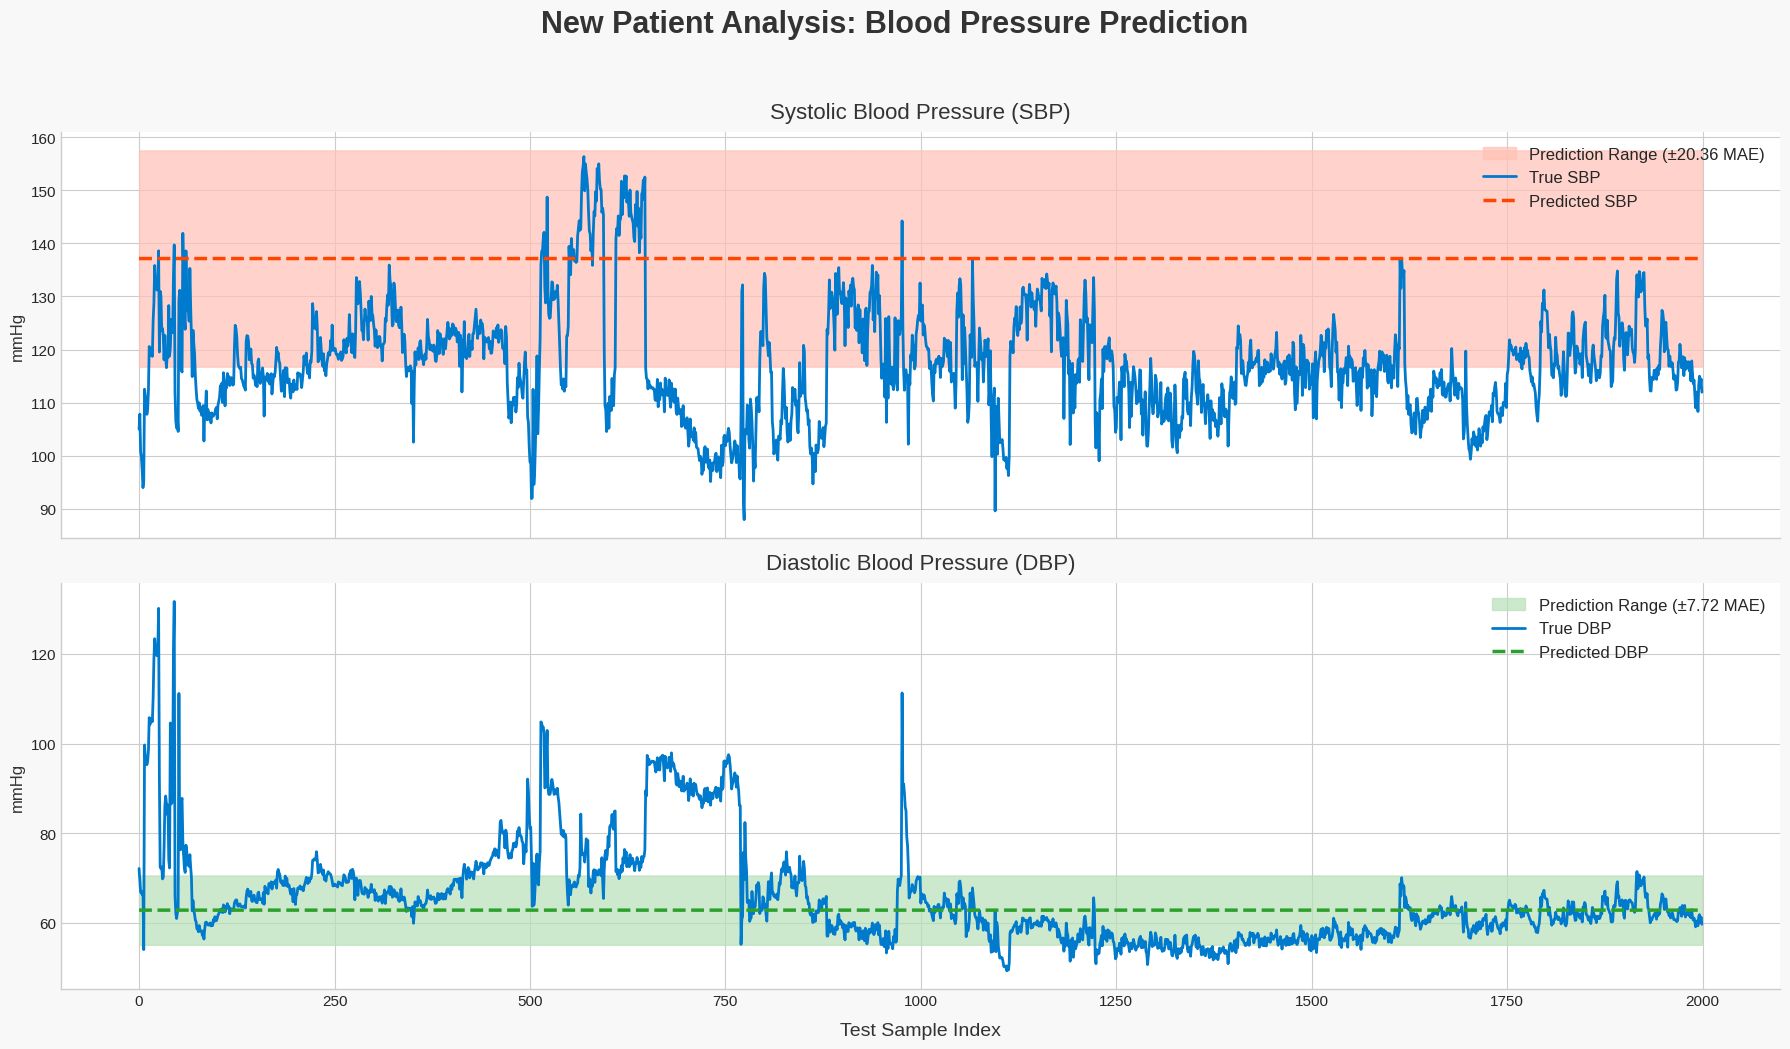

In [14]:
if __name__ == '__main__':
    # 1. p003949 환자로 훈련하고 모델 저장
    train_final_model(train_patient_path=FILE_PATH)

    # 2. 저장된 모델로 p009993 환자 평가
    evaluate_on_new_patient(test_patient_path=TEST_SET_PATH)